# Discrete Choice

Discrete choice models are models that model a single (mutually exclusive) choice, in contrast to the standard models where a quantity is estimated. 

In this notebook we will try to get you familiarized with discrete choice, the difference between logit and probit, and how to implement them (and more advanced models), using the module [statsmodels](https://www.statsmodels.org/stable/index.html).

### Linear Regression
As a lazy student we want to study as little as possible, but still pass the final test. Let's pretend we have a dataset of last year's students, with the hours they studied for the test, and whether or not they passed. From this dataset we can make an estimation how many hours we have to study ourselves to pass. If we would try a linear expression approach we would try to fit the function: 

\begin{equation}
 Y = \beta_0 + \beta_1 X_1
\end{equation}

where $Y$ equals the chance of passing, $\beta_0$ the base chance of passing, $\beta_1$ the increase of chance of passing per hour we study, and $X_1$ the hours a student studied.

First: We install statsmodels and test if we can import it.

In [1]:
from IPython.display import clear_output
!pip install statsmodels 
import statsmodels
clear_output()
print("Everything A-Okay!")

Everything A-Okay!


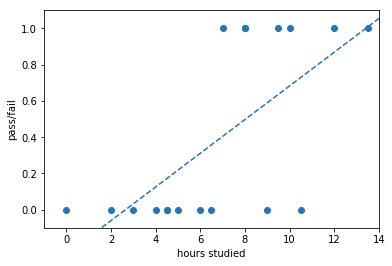

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# the hours each student studied for the test, and whether they passed or failed
students = {'hours': [0, 2, 3, 4, 4.5, 4.5, 5, 6, 6.5, 7, 8, 8, 9, 9.5, 10, 10.5, 12, 13.5],
            'passed': [False, False, False, False, False, False, False, False, False, True, True, True, False, True, True, False, True, True]}

# use ordinary least squares (OLS) to fit our function Y
intercept, slope = sm.OLS(students['passed'], 
                          sm.add_constant(students['hours'])).fit().params

# plot the results of the students
plt.scatter(students['hours'], students['passed'])
plt.xlabel('hours studied'); plt.ylabel('pass/fail')

# plot the results of the fit
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--')

# set proper axes
plt.xlim([-1, 14]); plt.ylim([-0.1, 1.1])

plt.show()

We fitted our $Y$ function with a simple linear square approach, by using the method [sm.OLS](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) from statsmodels. Its first argument is the $Y$ value we try to fit, and the second argument are the $\beta$ values we try to fit. Note that we have to add a constant value (`sm.add_constant`) if we want a $\beta_0$ value

The obvious problem with the linear regression approach is that we try to model the chance of pass (or failure), but our model can give values outside of the range (0, 1). If a student did not study the model gives a chance lower than 0% of succes, and after more than 14 hours of study the chance of passing is higher than a 100%! To solve this problem we need discrete models.

### Binary Discrete Choice
Discrete models are similar to our previous approach, except the $Y$ value is not modelled on a continuous scale, but is limited between discrete alternatives. To solve these models we need a **utility** function, which closely resembles the function we tried to fit using linear regression, but with some added noise $\epsilon$: 
\begin{equation}
 U = \beta_0 + \beta_1 X_1 + \epsilon \\
 \begin{cases}
 pass & U > 0\\
 fail & else\\
 \end{cases}
\end{equation}

This utility function represents the preference for an outcome. In our case if the utility is a number above zero, it means the student passes, otherwise the student fails. To get a probability from our utility we need a function $F$ which maps the utility to a probability between the range (0, 1).
\begin{equation}
 P_{n1} = F(U)
\end{equation}

Here we will discuss two of the most common $F$ funcitons, **Logit** & **Probit**.

### Logit (Logistic regression)
When using the Logit approach we assume that the log-odds of pass/failure can be expressed as a linear function of our input (the utility), and our unobserved fraction of the utility ($\epsilon$) follows a logistic distribution:
\begin{equation}
 log (\frac{P_{n1}}{1 - P_{n1}}) = U \\
 \frac{P_{n1}}{1 - P_{n1}} = e^U
\end{equation} 

which we can rewrite to:
\begin{equation}
 P_{n1} = \frac{e^U}{1 + e^U}
\end{equation} 

In the Logit case our function $F$ is just the sigmoid/logistic function! 

So what did we gain from this approach? Our values are now limited between the range (0, 1), but more importantly, we can interpret out coefficients as odds! If for instance after fitting our $\beta_1$ has a value of $1.1$, it means that for each hour of study the chance of passing  would be $e^{1.1} \approx 3$ times as likely to happen!

### Probit 
The probit model assumes that the unobserved fraction of the utility ($\epsilon$) follows a standard normal distribution:
\begin{equation}
P_{n1} = \Phi(\beta_0 + \beta_1 X_1)
\end{equation}
where $\Phi$ is the cumulative distribution function of the (standard) normal distribution.

### Difference
So what is the difference between a normal distribution and a logit distribution? Let's plot them both:

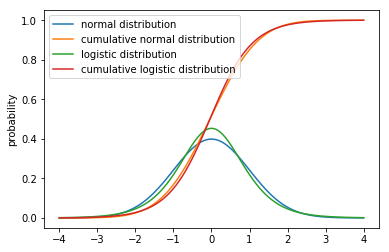

In [3]:
from scipy.stats import norm, logistic
import math

# standard normal distribution
mu = 0; std = 1
x = np.linspace(-4, 4, 100)

# plot the normal pdf & cdf
normal = norm.pdf(x, loc=mu, scale=std)
plt.plot(x, normal, label='normal distribution')
plt.plot(x, np.cumsum(normal) / sum(normal), label='cumulative normal distribution')

# plot the logistic pdf & cdf
logist = logistic.pdf(x, loc=mu, scale=std * math.sqrt(3) / math.pi)
plt.plot(x, logist, label='logistic distribution')
plt.plot(x, np.cumsum(logist) / sum(logist), label='cumulative logistic distribution')

plt.ylabel('probability')
plt.legend()
plt.show()

They are very similar! Note that the logit distribution has fatter tails, so it will produce more extreme values than the normal distribution. Now let's see how they differ in performance of the fit:

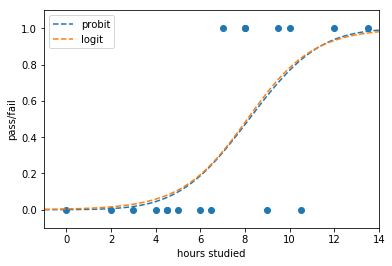

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                   18
Model:                         Probit   Df Residuals:                       16
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Jan 2019   Pseudo R-squ.:                  0.4260
Time:                        14:43:42   Log-Likelihood:                -6.9044
converged:                       True   LL-Null:                       -12.028
                                        LLR p-value:                  0.001368
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3222      1.427     -2.328      0.020      -6.119      -0.525
x1             0.4058      0.173      2.341      0.019       0.066       0.745
                           Logit Regression Results 

In [4]:
# plot the results of the students
plt.scatter(students['hours'], students['passed'])
plt.xlabel('hours studied'); plt.ylabel('pass/fail')

# set proper axes
plt.xlim([-1, 14]); plt.ylim([-0.1, 1.1])
x_vals = sm.add_constant(np.linspace(-1, 14, 100))

# use probit to fit our function
probit = sm.Probit(students['passed'], sm.add_constant(students['hours']))
pr_model = probit.fit(disp=0)  # disp=0 to silence the verbose function
pseudo_r_p = pr_model.prsquared

# plot the results of probit
y_vals = pr_model.predict(x_vals)
plt.plot(x_vals[:, 1], y_vals, '--', label='probit')

# use logit to fit our function
logit = sm.Logit(students['passed'], sm.add_constant(students['hours']))
lo_model = logit.fit(disp=0)  # disp=0 to silence the verbose function
pseudo_r_l = lo_model.prsquared

# plot the results of logit
y_vals = lo_model.predict(x_vals)
plt.plot(x_vals[:, 1], y_vals, '--', label='logit')

plt.legend()
plt.show()

# show summary of both models
print(pr_model.summary())
print(lo_model.summary())

In [ ]:
# so what is the probability of passing the course if you study 9 hours for the test?
# your answer has to be correct for at least two significant digits
chance = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert 0 <= chance <= 1

Even though the fitted parameters of both models are quite different, the actual fits are extremely close, and differ little in their predictions, pseudo R squares, or looks.

### Multinomial logit
When dealing with multiple discrete alternatives, we have to make use of multinomial discrete choice. We rewrite our original utility function into one utility function per choice, where the chance of choice $i$ is defined as such:
\begin{equation}
    P_i = Prob(U_i > U_j \quad \forall j \neq i)
\end{equation}

We generated a dataset of 250 students, which contains the students' income, distance to university, how lazy they are, and what transport (either bike, car, bus 40 or bus 240) they use to get to university.   

Implement multinomial logit yourself, take a look at [MNLogit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.MNLogit.html). Remember to add a constant (`sm.add_constant`) to our observed variables. Also note that you should use numeric labels, and not the text-label.

In [ ]:
import pandas as pd

# load our dataset
df = pd.read_csv('transport.csv', sep=';', usecols=['income', 'distance', 'lazy', 'transport', 'transport_id'])

# print the 'head' of the dataframe to get a feel for the data 
print(df.head())

# implement multinomial logit
# YOUR CODE HERE
raise NotImplementedError()

# let's see how it predicts on our own dataset (you should get at least 200 out of 250 predictions correct!)
# the predict function returns a dataframe shape (250, 4), where each column is the chance of that choice.
# Assume that the option with the highest chance is chosen
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert type(model).__name__ == 'MultinomialResultsWrapper'

### Logit limitations
- **Taste variation**: every students shares the same $\beta$ values, while this not necessarily has to be true. Some students might've done earlier courses which resemble a lot of the subject matter of the course, so they have a higher $\beta_0$ value, and some student might just be more efficient while learning, resulting in a higher $\beta_1$ value. Logit does not allow different $\beta$ values for its choice makers.
- **Independece of Irrelevant Alternatives (IIA)**: If we make people choose between two options (e.g. bulbasaur and squirtle), adding a third option (charmander) should not change peoples original order of the two options. For example: if someone prefers a squirtle over a bulbasaur, by also giving them the choice of a charmander, they should not suddenly like bulbasaur more. Multinomial logit does not allow independence of irrelevant alternatives.
- **Repeated choice**: Logit assumes no correlation in repeated choices. If a person takes the bike to work one day, it might influence him/her to take the bike the next day. Maybe he/she got lost, so won't take the bike again. Or the person gets to know the road better, so biking the next day becomes faster.


### Nested logit
When we look closer at the data we see that bus 240 and bus 40 are similar choices, and after a quick questionnaire we realize that if bus 40 does not go all student's will use bus 240 and vice versa. Multinomial logit violates this bus-dependency (independence of irrelevant alternatives). However if we would implement nested logit we would be guaranteed of this dependency:

![...](nested.png)

Your task now is to finish the NestedLogit class, which incorporates this logic. It should fit the choices bike, car, and bus using `sm.MNLogit` and the two different buses by `sm.Logit`. 

In [ ]:
class NestedLogit():
    def __init__(self, labels, variables):
        # YOUR CODE HERE
        raise NotImplementedError()

    def fit(self):
        """
        Method that fits the predictions of the NestedLogit.
        """        
        # YOUR CODE HERE
        raise NotImplementedError()

    def predict(self, variables):
        """
        Method that returns the predictions of the NestedLogit, based on the fit, shape (N, 4)
        """
        # YOUR CODE HERE
        raise NotImplementedError()
        
# Calls to NestedLogit
nlogit = NestedLogit(df['transport_id'], sm.add_constant(df[['income', 'distance', 'lazy']]))
nlogit.fit()
y_vals = nlogit.predict(sm.add_constant(df[['income', 'distance', 'lazy']]))
# How does nested logit compare to multinomial logit? You should get at least 170 predictions correct! 

In [ ]:
nlogit = NestedLogit(df['transport_id'], sm.add_constant(df[['income', 'distance', 'lazy']]))
nlogit.fit()
y_vals = nlogit.predict(sm.add_constant(df[['income', 'distance', 'lazy']]))
assert y_vals.shape == (250, 4)

In the file generate_data.py is the data generated. Can you design a dataset where NestedLogit outperforms MultiNomialLogit? Why does nested logit not outperform multinomial logit?

### Advanced models
For more complex logit models, such as mixed logit which allows for taste variation. Take a look at [PyLogit](https://github.com/timothyb0912/pylogit)!